In [231]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from keras.layers import Input, Embedding, Flatten
from keras.layers.merge import dot, add
from keras.regularizers import l2
from keras.models import Model
from keras.optimizers import Adam


# load dataset
df = pd.read_csv('ratings.csv')

# redefine ids
user_ids = df['userId'].unique()
movie_ids = df['movieId'].unique()
old2new_user_id = {id_old: idx for idx, id_old in enumerate(user_ids)}
old2new_movie_id = {id_old: idx for idx, id_old in enumerate(movie_ids)}
df['userId'] = df['userId'].apply(lambda x: old2new_user_id[x])
df['movieId'] = df['movieId'].apply(lambda x: old2new_movie_id[x])

# parameters
np.random.seed(42)
n_users = df['userId'].nunique()
n_movies = df['movieId'].nunique()
n_factors = 50

# model setup
user_in = Input(shape=[1,], dtype='int64', name='user_in')
user_emb = Embedding(n_users, n_factors, input_length=1, embeddings_regularizer=l2(1e-4))(user_in)
movie_in = Input(shape=[1,], dtype='int64', name='movie_in')
movie_emb = Embedding(n_movies, n_factors, input_length=1, embeddings_regularizer=l2(1e-4))(movie_in)
fn = dot([user_emb, movie_emb], axes=[2, 2])
fn = Flatten()(fn)

user_bias = Embedding(n_users, 1, input_length=1)(user_in)
user_bias = Flatten()(user_bias)
movie_bias = Embedding(n_movies, 1, input_length=1)(movie_in)
movie_bias = Flatten()(movie_bias)
fn = add([fn, user_bias])
fn = add([fn, movie_bias])

model = Model([user_in, movie_in], fn)
model.compile(Adam(.001), loss='mae')


# model trainning
df_tr, df_val = train_test_split(df, test_size=.2)
kwargs = {
    'x': [df_tr['userId'], df_tr['movieId']],
    'y': df_tr['rating'],
    'batch_size': 64,
    'epochs': 2,
    'validation_data': ([df_val['userId'], df_val['movieId']], df_val['rating']),
}
model.fit(**kwargs)

kwargs['epochs'] = 6
model.optimizer.lr = .01
model.fit(**kwargs)

kwargs['epochs'] = 16
model.optimizer.lr = .001
model.fit(**kwargs)

Train on 80668 samples, validate on 20168 samples
Epoch 1/2
10048/80668 [==>...........................] - ETA: 52s - loss: 3.4649

KeyboardInterrupt: 

In [176]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
user_in (InputLayer)            (None, 1)            0                                            
__________________________________________________________________________________________________
movie_in (InputLayer)           (None, 1)            0                                            
__________________________________________________________________________________________________
embedding_5 (Embedding)         (None, 1, 16)        9760        user_in[0][0]                    
__________________________________________________________________________________________________
embedding_6 (Embedding)         (None, 1, 16)        155584      movie_in[0][0]                   
__________________________________________________________________________________________________
dot_2 (Dot

In [177]:
def extract_weights(name, model):
    """Extract weights from a neural network model"""
    
    # Extract weights
    weight_layer = model.get_layer(name)
    weights = weight_layer.get_weights()[0]
    return weights

In [178]:
book_weights_class = extract_weights('embedding_6', model)
book_weights_class.shape


(9724, 16)

In [71]:
from numpy import inf
book_weights_class[book_weights_class == -inf] = 0.00000001
book_weights_class[book_weights_class == inf] = 0.00000001

In [179]:
book_weights_class

array([[ 1.51322693e-01, -1.84135482e-01, -1.06622979e-01, ...,
         1.85049996e-01, -1.32405413e-02, -2.48209327e-01],
       [-7.67936558e-02, -3.36802490e-02,  1.47610335e-02, ...,
         2.72894241e-02,  1.33049460e-02, -6.81979656e-02],
       [ 1.91818669e-01,  4.72102091e-02,  4.57657874e-02, ...,
         7.77008533e-02, -1.05119810e-01, -1.75126761e-01],
       ...,
       [-4.93000448e-03, -1.19983750e-19, -1.77583420e-10, ...,
        -2.85760290e-03,  5.71038062e-03, -9.50550567e-03],
       [-5.11768158e-32,  2.30644040e-32,  2.57939901e-33, ...,
        -4.52918914e-32, -1.90332049e-32, -3.06491785e-33],
       [-3.43521941e-03, -3.71732511e-13, -5.72988165e-06, ...,
        -4.42158896e-03,  1.57761457e-03,  4.99371765e-03]], dtype=float32)

In [180]:
from sklearn.manifold import TSNE

In [181]:
def reduce_dim(weights, components = 3):
    """Reduce dimensions of embeddings"""
    return TSNE(components, metric = 'cosine').fit_transform(weights)


In [182]:
book_r = reduce_dim(book_weights_class, components = 2)
book_r.shape

C:\Users\happy\Anaconda2\envs\py36\lib\site-packages\sklearn\utils\extmath.py:71: RuntimeWarning: invalid value encountered in sqrt
  np.sqrt(norms, norms)


(9724, 2)

In [183]:
from IPython.core.interactiveshell import InteractiveShell

# Set shell to show all lines of output
InteractiveShell.ast_node_interactivity = 'all'

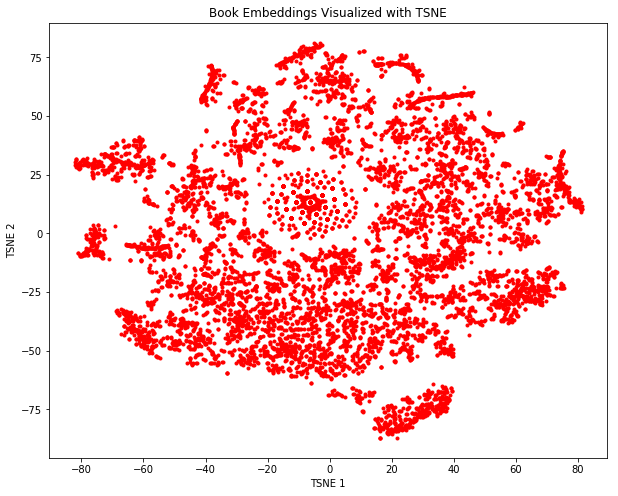

In [184]:
import pandas as pd
import matplotlib.pyplot as plt
InteractiveShell.ast_node_interactivity = 'last'

plt.figure(figsize = (10, 8))
plt.plot(book_r[:, 0], book_r[:, 1], 'r.')
plt.xlabel('TSNE 1'); plt.ylabel('TSNE 2'); plt.title('Book Embeddings Visualized with TSNE');

In [185]:
df2 = pd.read_csv('movies.csv')
df2['movieId']
df2['movieId'] = df2['movieId'].apply(lambda x: old2new_movie_id[x] if x in old2new_movie_id.keys() else 0)

In [186]:
from collections import Counter, OrderedDict

def count_items(l):
    """Return ordered dictionary of counts of objects in `l`"""
    
    # Create a counter object
    counts = Counter(l)
    
    # Sort by highest count first and place in ordered dictionary
    counts = sorted(counts.items(), key = lambda x: x[1], reverse = True)
    counts = OrderedDict(counts)
    
    return counts
genre_counts = count_items(df2.genres)

In [187]:
len(df2)

9742

In [214]:
# Include 10 most popular genres
genre_to_include = list(genre_counts.keys())[:4]

In [215]:
genre_to_include

['Drama', 'Comedy', 'Comedy|Drama', 'Comedy|Romance']

In [216]:
idx_include = []
genres = []
a = df2[2:2+1]
a.genres.item()

'Comedy|Romance'

In [217]:
for i in range(len(df2)):
    if df2[i:i+1]['genres'].item() in genre_to_include:
        idx_include.append(df2[i:i+1].movieId.item())
        genres.append(df2[i:i+1]['genres'].item().capitalize())
len(idx_include)

2797

In [218]:
n_movies

9724

In [219]:
ints, gen = pd.factorize(genres)
max(ints)

3

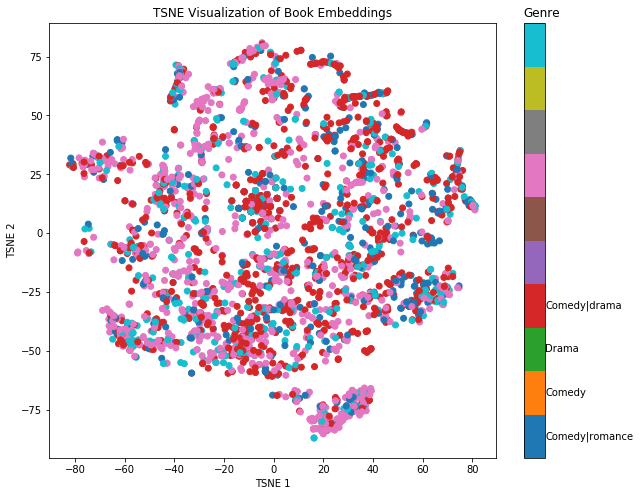

In [220]:
plt.figure(figsize = (10, 8))

# Plot embedding
plt.scatter(book_r[idx_include, 0], book_r[idx_include, 1], 
            c = ints, cmap = plt.cm.tab10)

# Add colorbar and appropriate labels
cbar = plt.colorbar()
cbar.set_ticks([])
for j, lab in enumerate(gen):
    cbar.ax.text(1, (2 * j + 1) / ((10) * 2), lab, ha='left', va='center')
cbar.ax.set_title('Genre', loc = 'left')


plt.xlabel('TSNE 1'); plt.ylabel('TSNE 2'); plt.title('TSNE Visualization of Book Embeddings');

In [174]:
max(idx_include)

9723

In [60]:
book_r[idx_include[:-10],0]

array([-39.975853, -19.660017, -36.858303, ..., -28.186073, -27.971592,
       -79.94051 ], dtype=float32)

In [90]:
old2new_movie_id

{1: 0,
 3: 1,
 6: 2,
 47: 3,
 50: 4,
 70: 5,
 101: 6,
 110: 7,
 151: 8,
 157: 9,
 163: 10,
 216: 11,
 223: 12,
 231: 13,
 235: 14,
 260: 15,
 296: 16,
 316: 17,
 333: 18,
 349: 19,
 356: 20,
 362: 21,
 367: 22,
 423: 23,
 441: 24,
 457: 25,
 480: 26,
 500: 27,
 527: 28,
 543: 29,
 552: 30,
 553: 31,
 590: 32,
 592: 33,
 593: 34,
 596: 35,
 608: 36,
 648: 37,
 661: 38,
 673: 39,
 733: 40,
 736: 41,
 780: 42,
 804: 43,
 919: 44,
 923: 45,
 940: 46,
 943: 47,
 954: 48,
 1009: 49,
 1023: 50,
 1024: 51,
 1025: 52,
 1029: 53,
 1030: 54,
 1031: 55,
 1032: 56,
 1042: 57,
 1049: 58,
 1060: 59,
 1073: 60,
 1080: 61,
 1089: 62,
 1090: 63,
 1092: 64,
 1097: 65,
 1127: 66,
 1136: 67,
 1196: 68,
 1197: 69,
 1198: 70,
 1206: 71,
 1208: 72,
 1210: 73,
 1213: 74,
 1214: 75,
 1219: 76,
 1220: 77,
 1222: 78,
 1224: 79,
 1226: 80,
 1240: 81,
 1256: 82,
 1258: 83,
 1265: 84,
 1270: 85,
 1275: 86,
 1278: 87,
 1282: 88,
 1291: 89,
 1298: 90,
 1348: 91,
 1377: 92,
 1396: 93,
 1408: 94,
 1445: 95,
 1473: 96,
 

In [93]:
max(df['movieId'])

9723

In [229]:
df3 = pd.read_csv('u.data.csv',sep='|')

In [230]:
df3

,user.id,item.id,rating,timestamp
0,196,242,3,881250949
1,186,302,3,891717742
2,22,377,1,878887116
3,244,51,2,880606923
4,166,346,1,886397596
5,298,474,4,884182806
6,115,265,2,881171488
7,253,465,5,891628467
8,305,451,3,886324817
9,6,86,3,883603013
